In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

news_df=pd.read_csv('/content/gdrive/MyDrive/FS-Sem3/CompanyProject_RegHub/news_df_with_top4_signals.csv')
print(f"Length of raw dataframe = {len(news_df)}")
news_df.head(2)

Mounted at /content/gdrive
Length of raw dataframe = 3168


,id,news_date,news_title,news_content,companies_in_news,news_content_embeddings,signal_1,signal_2,signal_3,signal_4
0,maretBeatPresfiling20231003,2023-10-03T15:45:10.000Z,K.J. Harrison & Partners Inc Boosts Stake in C...,Deutsche Bank AG has acquired an additional 49...,"Berenberg Bank, Sartorius","tensor([ 8.2298e-03, -1.0426e-01, -1.6461e-02,...",Capital_Markets_Stock_Analysis_cos,Financial_Deals_cos,Strategic_Steps_cos,Financial_Partnerships_cos
1,busTIMESPresesginvestingubs,2023-10-03T15:35:31.000Z,Conference aims to connect investors as ESG tr...,The UBS APAC Sustainable Finance Conference 20...,"Answer:\n\nBerenberg, Sebastian Bray","tensor([ 1.5170e-02, 7.4811e-02, -7.3396e-02,...",Financial_Partnerships_cos,Financial_Deals_cos,Capital_Markets_Stock_Analysis_cos,Technological_Deals_Collaborations_cos


<ipython-input-3-e9a3f05f15a8>:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


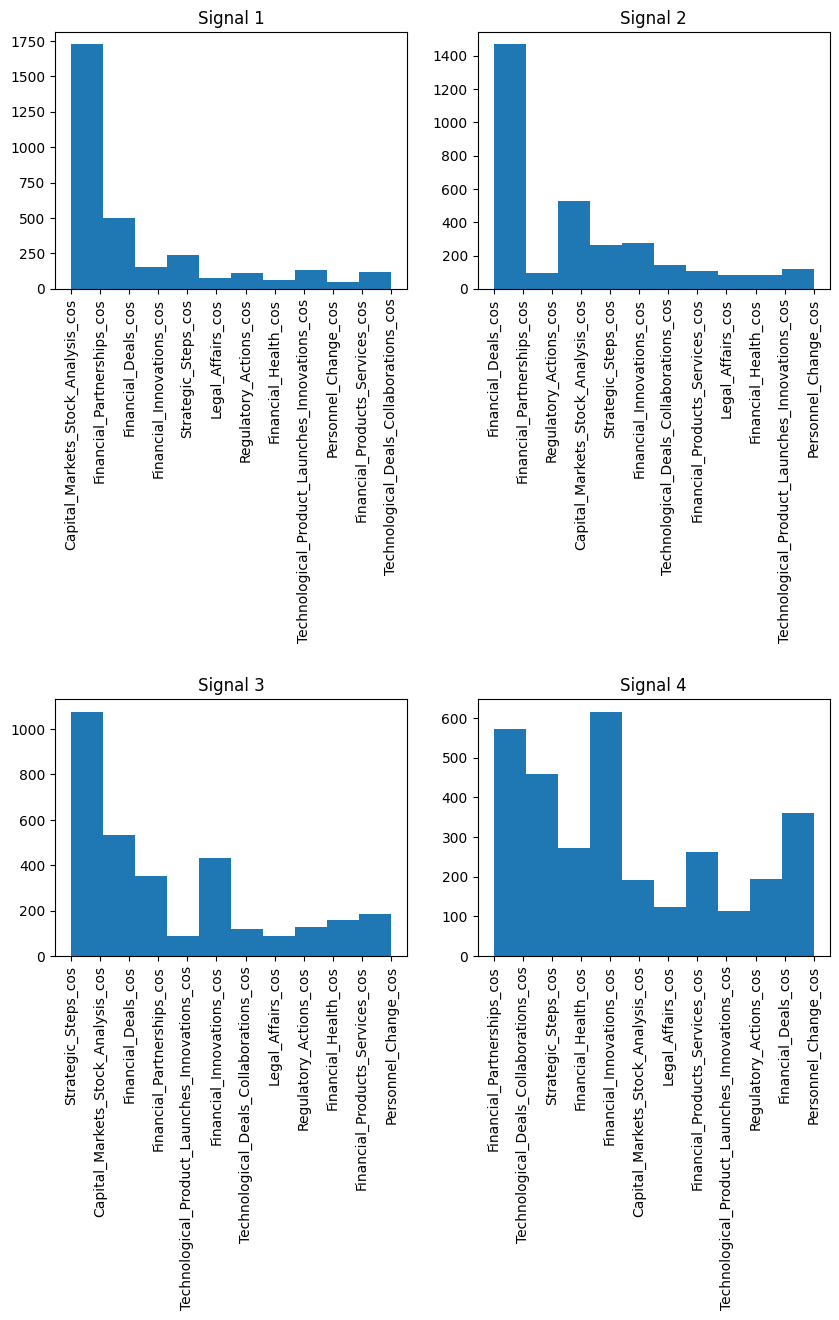

In [3]:
import matplotlib.gridspec as gridspec

# a 2x2 subplot layout
fig = plt.figure(figsize=(10, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], hspace=1.6) # gap between the top and bottom rows

ax1 = plt.subplot(gs[0, 0])
ax1.hist(news_df['signal_1'])
ax1.set_title('Signal 1')
ax1.tick_params(axis='x', rotation=90)

ax2 = plt.subplot(gs[0, 1])
ax2.hist(news_df['signal_2'])
ax2.set_title('Signal 2')
ax2.tick_params(axis='x', rotation=90)

ax3 = plt.subplot(gs[1, 0])
ax3.hist(news_df['signal_3'])
ax3.set_title('Signal 3')
ax3.tick_params(axis='x', rotation=90)

ax4 = plt.subplot(gs[1, 1])
ax4.hist(news_df['signal_4'])
ax4.set_title('Signal 4')
ax4.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [4]:
%%capture
!pip install -U sentence-transformers
!pip install numerizer
!python -m spacy download en_core_web_lg

from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

from spacy import load
import numerizer
nlp = load('en_core_web_lg')

In [5]:
# our pre-defined dictionary of events/signals
event_descriptions = {
    "event": [
        "Financial_Products_Services",
        "Financial_Deals",
        "Financial_Partnerships",
        "Financial_Innovations",
        "Financial_Health",
        "Strategic_Steps",
        "Personnel_Change",
        "Technological_Product_Launches_Innovations",
        "Technological_Deals_Collaborations",
        "Regulatory_Actions",
        "Legal_Affairs",
        "Capital_Markets_Stock_Analysis"
    ],
    "description": [
        "News related to the introduction, withdrawal, or alterations in financial instruments, services, or products offered by a company. This includes launches, discontinuations, and changes in features.",
        "Reports covering financial transactions, such as the placement of new funds or assets in the capital market, as well as support for customer Initial Public Offerings (IPOs) or mergers and acquisitions.",
        "News highlighting collaborations, alliances, or partnerships entered into by a company for financial purposes. This can include joint ventures, strategic alliances, or long-term partnerships.",
        "News regarding the development and introduction of novel financial products or services, often accompanied by whitepapers or patents that showcase innovative approaches or technologies.",
        "Coverage related to the overall well-being of a company from a financial perspective. This encompasses aspects like bankruptcy, valuation changes, solvency issues, and other indicators of financial stability or distress.",
        "News outlining strategic decisions made by a company, such as initial public offerings (IPOs), mergers, acquisitions, expansions, fundraise activities, stock buybacks, and other significant corporate moves.",
        "Reports on changes in a company's workforce, including hirings, firings, the number of employees affected, mass recruitments, and any notable shifts in personnel.",
        "Information about the release of new technological products, services, or innovations. This category covers technological advancements, patents, and research papers hinting at potential tech developments.",
        "News highlighting partnerships, collaborations, or deals related to technology, including joint ventures, technology-sharing agreements, or collaborations for research and development.",
        "Reports on actions taken by or against a company by regulatory bodies. This includes compliance issues, regulatory investigations, and any changes in regulations affecting the company.",
        "News covering legal matters, including lawsuits, penalties, victories, sanctions, warnings, and other legal or compliance-related developments involving the company.",
        "Analyses and reports provided by companies, often banks, regarding stock performance, capital market trends, and insights into specific markets or assets."
    ]
}

events_df = pd.DataFrame(event_descriptions) # dataframe from dictionary
events_df['description_embeddings'] = ""

# re- creating embeddings of the descriptions of the signals
for index, row in events_df.iterrows():
  events_df.at[index, 'description_embeddings'] = model.encode(row['description'], convert_to_tensor=True)

events_df.head()

,event,description,description_embeddings
0,Financial_Products_Services,"News related to the introduction, withdrawal, ...","[tensor(0.0042, device='cuda:0'), tensor(0.016..."
1,Financial_Deals,"Reports covering financial transactions, such ...","[tensor(0.0492, device='cuda:0'), tensor(-0.03..."
2,Financial_Partnerships,"News highlighting collaborations, alliances, o...","[tensor(0.0351, device='cuda:0'), tensor(-0.05..."
3,Financial_Innovations,News regarding the development and introductio...,"[tensor(-0.0363, device='cuda:0'), tensor(-0.0..."
4,Financial_Health,Coverage related to the overall well-being of ...,"[tensor(0.0044, device='cuda:0'), tensor(0.092..."


In [6]:
company_of_interest = "Berenberg Bank" # company for which we want to analyze the news
signal_of_interest = "Capital_Markets_Stock_Analysis"


company_all_news_df = news_df[news_df['companies_in_news'].astype(str).str.contains(company_of_interest, case=False)]
company_all_news_df = company_all_news_df.sort_values(by='news_date', ascending = False)
# company_news_df = company_all_news_df[company_all_news_df['signal_1'] == signal_of_interest + '_cos'].drop(columns=['signal_2', 'signal_3', 'signal_4']) # filtering news with signal_of_interest as signal_1
company_news_df = company_all_news_df[
    (company_all_news_df['signal_1'] == signal_of_interest + '_cos') |
    (company_all_news_df['signal_2'] == signal_of_interest + '_cos') |
    (company_all_news_df['signal_3'] == signal_of_interest + '_cos') |
    (company_all_news_df['signal_4'] == signal_of_interest + '_cos')
]
# extracting dates from date-time-stamps
company_news_df['news_date_simplified'] = pd.to_datetime(company_news_df['news_date'].str[:10]) # extract first 10 characters and convert to datetime
company_news_df = company_news_df.reset_index(drop=True)
print(f"length of filtered dataframe = {len(company_news_df)}")

cols = ['id', 'news_date',	'news_date_simplified', 'news_title',	'news_content',	'companies_in_news',	'news_content_embeddings',	'signal_1',	'signal_2',	'signal_3',	'signal_4']
company_news_df = company_news_df[cols] #re-arranging columns
company_news_df.head(5)

length of filtered dataframe = 549


<ipython-input-6-dc93a37280c7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_news_df['news_date_simplified'] = pd.to_datetime(company_news_df['news_date'].str[:10]) # extract first 10 characters and convert to datetime


,id,news_date,news_date_simplified,news_title,news_content,companies_in_news,news_content_embeddings,signal_1,signal_2,signal_3,signal_4
0,defWorldReporestupdate2html,2023-10-30 09:27:47,2023-10-30,Talanx AG (OTCMKTS:TNXXF) Short Interest Updat...,Berenberg Bank has upgraded its rating on Tala...,"Berenberg Bank, Talanx, HSBC.","tensor([-6.2445e-02, -5.9690e-02, -4.7869e-02,...",Capital_Markets_Stock_Analysis_cos,Financial_Deals_cos,Strategic_Steps_cos,Financial_Products_Services_cos
1,defyHSBCStocweredbyhsbchtml,2023-10-28 16:40:01,2023-10-28,Reckitt Benckiser Group (OTCMKTS:RBGLY) Stock ...,Berenberg Bank has reduced its target price fo...,"Reckitt Benckiser Group, Berenberg Bank.","tensor([ 3.4826e-02, -4.2792e-03, -7.7424e-03,...",Capital_Markets_Stock_Analysis_cos,Financial_Deals_cos,Strategic_Steps_cos,Financial_Products_Services_cos
2,abcshadowPresmideast104342444,2023-10-26 19:28:46,2023-10-26,Europe's central bank is set to halt rate hike...,The European Central Bank's (ECB) message appe...,"Berenberg bank, European Central Bank.","tensor([ 2.8340e-02, 2.0919e-02, -3.0415e-02,...",Capital_Markets_Stock_Analysis_cos,Financial_Deals_cos,Financial_Products_Services_cos,Regulatory_Actions_cos
3,fin1023Presoverweight915798,2023-10-21 16:04:27,2023-10-21,MTU Aero Engines Overweight von JP Morgan Chas...,JP Morgan Chase & Co. has announced its plan t...,"JP Morgan Chase & Co, Berenberg Bank, Joh. Ber...","tensor([-1.3338e-02, 6.3491e-02, -2.3519e-02,...",Capital_Markets_Stock_Analysis_cos,Financial_Deals_cos,Financial_Innovations_cos,Strategic_Steps_cos
4,efiareersJobk252Cny252Cusa,2023-10-21 05:59:26,2023-10-21,Investment Banking Analyst job in New York at ...,"The article is not accessible, however, it men...","Berenberg Bank, eFinancialCareers","tensor([ 3.0946e-02, -8.2079e-02, -8.6097e-02,...",Capital_Markets_Stock_Analysis_cos,Financial_Deals_cos,Financial_Innovations_cos,Financial_Partnerships_cos


In [7]:
random_row = 7
print(type(company_news_df.news_content_embeddings[random_row])) # this outputs type as string

# since "news_content_embeddings" column should contain tensors, we change the string items back to tensors
for index, row in company_news_df.iterrows():
  company_news_df.at[index, 'news_content_embeddings'] = model.encode(row['news_content'], convert_to_tensor=True)

print(type(company_news_df.news_content_embeddings[random_row])) # now this should be type 'tensor'

<class 'str'>
<class 'torch.Tensor'>


In [8]:
# demonstration of how Spacy's 'numerize' extension works
doc = nlp('In the year 2023, I traveled 5,000 miles to attend ten conferences, where I gave 15 presentations, met with twenty industry experts, and exchanged business cards with hundreds of attendees.')
print(doc._.numerize())
print(len(doc._.numerize()))

{the year 2023: 'the year 2023', 5,000 miles: '5,000 miles', ten: '10', 15: '15', twenty: '20', hundreds: '100s'}
6


In [9]:
# now we evaluate news features in order to 'rank' news items

# feature 1 --> length of news item
company_news_df['news_length'] = company_news_df['news_content'].apply(lambda x: len(x.split()))  # word count as length
# feature 2 --> relevance of news item
company_news_df['news_relevance'] = company_news_df['news_content_embeddings'].apply(lambda x: util.pytorch_cos_sim(x, events_df.loc[events_df['event'] == signal_of_interest, 'description_embeddings'].iloc[0]).item())  # relevance = cosine similarity between 'news embedding' and 'signal/event descriprion'
# feature 3 --> age of news item
company_news_df['news_age'] = (datetime.now() - company_news_df['news_date_simplified']).dt.days + 1 # evaluating age of news in days
# feature 4 --> count of 'numbers' discussed in the news item
company_news_df['news_number_count'] = company_news_df['news_content'].apply(lambda x: len(nlp(x)._.numerize()))  # count of 'numbers' discussed in the news body evaluated using Spacy's 'numerize' extension

# filtering dataframe for latest 'n' days worth of news
n = 100
ndays_company_news_df = company_news_df[company_news_df['news_age']<=n]
print(len(ndays_company_news_df))
ndays_company_news_df.head()

47


,id,news_date,news_date_simplified,news_title,news_content,companies_in_news,news_content_embeddings,signal_1,signal_2,signal_3,signal_4,news_length,news_relevance,news_age,news_number_count
0,defWorldReporestupdate2html,2023-10-30 09:27:47,2023-10-30,Talanx AG (OTCMKTS:TNXXF) Short Interest Updat...,Berenberg Bank has upgraded its rating on Tala...,"Berenberg Bank, Talanx, HSBC.","[tensor(-0.0624, device='cuda:0'), tensor(-0.0...",Capital_Markets_Stock_Analysis_cos,Financial_Deals_cos,Strategic_Steps_cos,Financial_Products_Services_cos,57,0.347074,44,0
1,defyHSBCStocweredbyhsbchtml,2023-10-28 16:40:01,2023-10-28,Reckitt Benckiser Group (OTCMKTS:RBGLY) Stock ...,Berenberg Bank has reduced its target price fo...,"Reckitt Benckiser Group, Berenberg Bank.","[tensor(0.0348, device='cuda:0'), tensor(-0.00...",Capital_Markets_Stock_Analysis_cos,Financial_Deals_cos,Strategic_Steps_cos,Financial_Products_Services_cos,29,0.135117,46,0
2,abcshadowPresmideast104342444,2023-10-26 19:28:46,2023-10-26,Europe's central bank is set to halt rate hike...,The European Central Bank's (ECB) message appe...,"Berenberg bank, European Central Bank.","[tensor(0.0283, device='cuda:0'), tensor(0.020...",Capital_Markets_Stock_Analysis_cos,Financial_Deals_cos,Financial_Products_Services_cos,Regulatory_Actions_cos,86,0.304180,48,0
3,fin1023Presoverweight915798,2023-10-21 16:04:27,2023-10-21,MTU Aero Engines Overweight von JP Morgan Chas...,JP Morgan Chase & Co. has announced its plan t...,"JP Morgan Chase & Co, Berenberg Bank, Joh. Ber...","[tensor(-0.0133, device='cuda:0'), tensor(0.06...",Capital_Markets_Stock_Analysis_cos,Financial_Deals_cos,Financial_Innovations_cos,Strategic_Steps_cos,96,0.336457,53,1
4,efiareersJobk252Cny252Cusa,2023-10-21 05:59:26,2023-10-21,Investment Banking Analyst job in New York at ...,"The article is not accessible, however, it men...","Berenberg Bank, eFinancialCareers","[tensor(0.0309, device='cuda:0'), tensor(-0.08...",Capital_Markets_Stock_Analysis_cos,Financial_Deals_cos,Financial_Innovations_cos,Financial_Partnerships_cos,30,0.404161,53,0


In [10]:
# now we combine features and 'rank' news items published in the latest n-days window:

# normalizing length for combining features; larger text length means MORE relevant news
ndays_company_news_df['news_length_normalized'] = (ndays_company_news_df['news_length'] - ndays_company_news_df['news_length'].min()) / (ndays_company_news_df['news_length'].max() - ndays_company_news_df['news_length'].min())

# normalizing number_count for combining features; more numbers means MORE relevant news
ndays_company_news_df['news_number_count_normalized'] = (ndays_company_news_df['news_number_count'] - ndays_company_news_df['news_number_count'].min()) / (ndays_company_news_df['news_number_count'].max() - ndays_company_news_df['news_number_count'].min())

# normalizing age for combining features; large age means LESS relevant news
ndays_company_news_df['news_age_normalized'] = 1 - ((ndays_company_news_df['news_age'] - ndays_company_news_df['news_age'].min()) / (ndays_company_news_df['news_age'].max() - ndays_company_news_df['news_age'].min()))

# combining features by assigning weights
weight_length = 0.15
weight_relevance = 0.6
weight_number_count = 0.15
weight_age = 1 - weight_length - weight_relevance - weight_number_count
ndays_company_news_df['combined_feature'] = (weight_length * ndays_company_news_df['news_length_normalized']) + (weight_relevance * ndays_company_news_df['news_relevance']) + (weight_number_count * ndays_company_news_df['news_number_count_normalized']) + (weight_age * ndays_company_news_df['news_age_normalized'])

# assign rankings based on the final combined feature
ranked_ndays_company_news_df = ndays_company_news_df.sort_values(by='combined_feature', ascending=False)

ranked_ndays_company_news_df[['id', 'news_date', 'news_title', 'news_content', 'companies_in_news', 'signal_1',	'signal_2',	'signal_3',	'signal_4', 'news_length', 'news_relevance', 'news_age', 'news_number_count', 'combined_feature']].head()

<ipython-input-10-6af260e45637>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndays_company_news_df['news_length_normalized'] = (ndays_company_news_df['news_length'] - ndays_company_news_df['news_length'].min()) / (ndays_company_news_df['news_length'].max() - ndays_company_news_df['news_length'].min())
<ipython-input-10-6af260e45637>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndays_company_news_df['news_number_count_normalized'] = (ndays_company_news_df['news_number_count'] - ndays_company_news_df[

,id,news_date,news_title,news_content,companies_in_news,signal_1,signal_2,signal_3,signal_4,news_length,news_relevance,news_age,news_number_count,combined_feature
34,invngcomPresstors93CH3176822,2023-09-18T20:05:43.000Z,PBOC intensifies efforts to stabilize trade at...,The article discusses the declining profitabil...,"Berenberg Bank, Financial Services Provider",Capital_Markets_Stock_Analysis_cos,Financial_Deals_cos,Financial_Innovations_cos,Financial_Partnerships_cos,125,0.489214,86,1,0.482140
21,einNNewsPres02billionby2027,2023-10-03T12:10:30.000Z,Investment Banking & Trading Services Market S...,The article discusses how major global investm...,Berenberg Bank.,Capital_Markets_Stock_Analysis_cos,Regulatory_Actions_cos,Financial_Deals_cos,Financial_Health_cos,97,0.515682,71,0,0.459699
5,dirrviewsStocrgbank4121130347,2023-10-20 23:57:29,Greggs plc 54.1% potential upside indicated by...,Berenberg Bank has set a target price of 3550 ...,"Greggs plc, Berenberg Bank.",Capital_Markets_Stock_Analysis_cos,Financial_Deals_cos,Strategic_Steps_cos,Financial_Products_Services_cos,82,0.246388,54,4,0.430903
24,newoNewsPresess110000524html,2023-10-02T14:15:14.000Z,What's at Stake in Trump's $250 Million Busine...,The article discusses the connection between D...,"Berenberg Bank, Zurich Insurance Group Ltd, Mo...",Capital_Markets_Stock_Analysis_cos,Financial_Partnerships_cos,Financial_Deals_cos,Financial_Innovations_cos,114,0.263829,72,3,0.419230
3,fin1023Presoverweight915798,2023-10-21 16:04:27,MTU Aero Engines Overweight von JP Morgan Chas...,JP Morgan Chase & Co. has announced its plan t...,"JP Morgan Chase & Co, Berenberg Bank, Joh. Ber...",Capital_Markets_Stock_Analysis_cos,Financial_Deals_cos,Financial_Innovations_cos,Strategic_Steps_cos,96,0.336457,53,1,0.415452


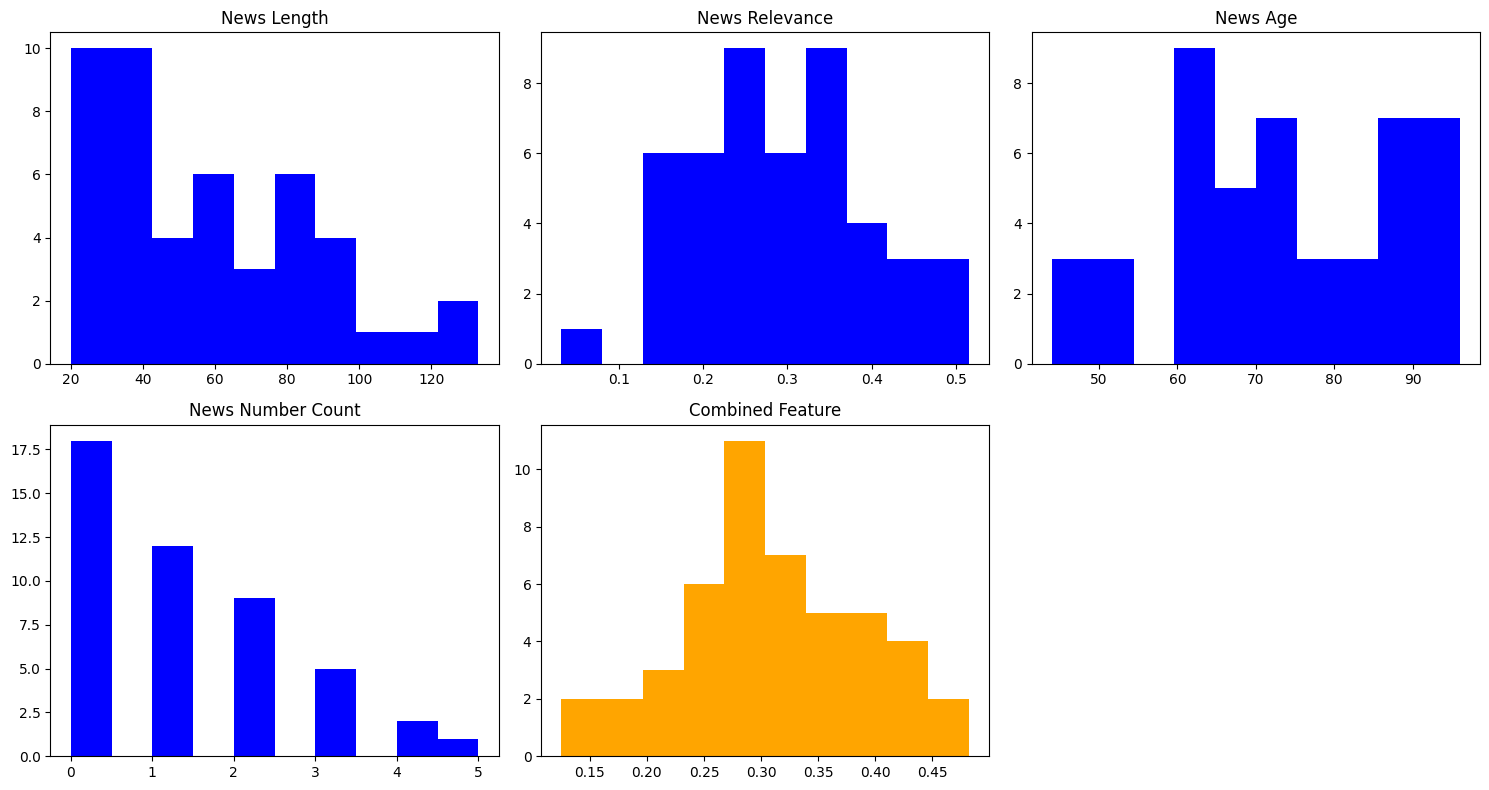

In [11]:
# plotting histograms in each subplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

axes[0, 0].hist(ranked_ndays_company_news_df['news_length'], color='blue')
axes[0, 0].set_title('News Length')

axes[0, 1].hist(ranked_ndays_company_news_df['news_relevance'], color='blue')
axes[0, 1].set_title('News Relevance')

axes[0, 2].hist(ranked_ndays_company_news_df['news_age'], color='blue')
axes[0, 2].set_title('News Age')

axes[1, 0].hist(ranked_ndays_company_news_df['news_number_count'], color='blue')
axes[1, 0].set_title('News Number Count')

axes[1, 1].hist(ranked_ndays_company_news_df['combined_feature'], color='orange')
axes[1, 1].set_title('Combined Feature')

axes[1, 2].axis('off') # an empty subplot to maintain the layout

plt.tight_layout()
plt.show()


In [12]:
ranked_ndays_company_news_df = ranked_ndays_company_news_df.reset_index(drop=True)

number = 10
for index, row in ranked_ndays_company_news_df.head(number).iterrows():
    news_item = row['news_content']
    rank_score = row['combined_feature']
    print(f"{round(rank_score,3)}: {news_item}")
    print("*****")

0.482: The article discusses the declining profitability of major banks, including JPMorgan Chase & Co., HSBC Holdings Plc, Deutsche Bank AG, BNP Paribas, and UBS Group AG. These banks have been struggling to generate substantial revenue due to low interest rates and increased competition. The low interest rates have reduced the profitability of traditional banking activities, such as lending and deposit-taking. Moreover, the rise of fintech companies and digital platforms has intensified competition in the banking sector. Additionally, regulatory requirements and increasing costs have further impacted the profitability of these banks. In contrast, Tesla, the electric vehicle manufacturer, has experienced significant growth and success in recent years, causing its stock price to soar. The article highlights the diverging financial performance of these major banks and Tesla.
*****
0.46: The article discusses how major global investment banks, including Deutsche Bank, Credit Suisse, JPMo